In [5]:
import numpy as np

###################################
# Control parameters
###################################
_n_rings = 5
scale_factor = 0.01
pitch = 0.5664 * scale_factor
center = [0.0,0.0]
###################################

# Defining input variables
x0 = 0.0;
y0 = 0.0;

x1 = 0.0;
y1 = 0.0;

a1 = 0.0;
a2 = 0.0

avg_coor_x = 0.0;
avg_coor_y = 0.0;

dist = 0.0;
dist0 = 0.0;

kgap = 0;
icorner = 0;
positive_flow = 1.0;
negative_flow = -1.0;

_rod_diameter = 0.4419*scale_factor
_flat_to_flat = 4.64*scale_factor
_duct_to_rod_gap = (_flat_to_flat - (_n_rings - 1)*2*pitch)/2

#################################
# Defining rod positions
#################################

theta = 0.0;
dtheta = 0.0;
distance = 0.0;
theta1 = 0.0;
theta_corrected = 0.0;
pi = np.pi;
k = 0;

_rod_position = [[0.0,0.0]];
for i in range(1,_n_rings):
    dtheta, theta = 2.0 * pi / (i * 6), 0.0;
    for j in range(i*6):
        k = k + 1;
        theta1 = (theta + 1.0e-10) % (pi / 3.0);
        distance = ((pow(i * pitch, 2) + (theta1 / dtheta * pitch)**2 -
                     2.0 * i * pitch * (theta1 / dtheta * pitch) * np.cos(pi / 3.0)))**0.5;
        theta_corrected = np.arccos(1.0 / (i * pitch) / distance / 2.0 *
          ((i * pitch)**2.0 + (distance)**2.0 - (theta1 / dtheta * pitch)**2.0));
        if (theta1 < 1.0e-6):
            theta_corrected = theta;
        else:
            if (theta > pi / 3.0 and theta <= 2.0 / 3.0 * pi):
                theta_corrected = theta_corrected + pi / 3.0;
            elif (theta > 2.0 / 3.0 * pi and theta <= pi):
                theta_corrected = theta_corrected + 2.0 / 3.0 * pi;
            elif (theta > pi and theta <= 4.0 / 3.0 * pi):
                theta_corrected = theta_corrected + pi;
            elif (theta > 4.0 / 3.0 * pi and theta <= 5.0 / 3.0 * pi):
                theta_corrected = theta_corrected + 4.0 / 3.0 * pi;
            elif (theta > 5.0 / 3.0 * pi and theta <= 2.0 * pi):
                theta_corrected = theta_corrected + 5.0 / 3.0 * pi;
        pos_x = center[0] + distance * np.cos(theta_corrected)
        pos_y = center[0] + distance * np.sin(theta_corrected)
        _rod_position.append([pos_x, pos_y])
        theta = theta + dtheta;
        
        
#################################
# Defining rod positions in rings
#################################
_nrods = len(_rod_position)
_rods_in_rings = {}; k=0
k += 1; _rods_in_rings[0] = [k];
for i in range(1,_n_rings):
    loc_list = []
    for j in range(0, i * 6):
        k+= 1; loc_list.append(k);
    _rods_in_rings[i] = loc_list
    

#################################
# Number of channels
#################################
chancount = 0
for j in range(_n_rings - 1):
    chancount += j * 6
_n_channels = chancount + _nrods - 1 + (_n_rings - 1) * 6 + 6;


#################################
# Suchannels positions
#################################
_subchannel_to_rod_map = {} # Reserve 3
_subch_type = {}
_n_gaps = _n_channels + _nrods - 1;
_gap_to_chan_map = {}
gap_fill = {}
_chan_to_gap_map = {} # Reserve 3
_gap_pairs_sf = {}
_chan_pairs_sf = {}
_gij_map = {}
_sign_id_crossflow_map = {} # Reserve 3
_gap_to_rod_map = {} # Reserve 2
_gap_type = {}
_subchannel_position = {} # Reserve 3

k = 0;
kgap = 0;

for i in range(1, _n_rings):
    # Find closest rod at back ring
    for j in range(len(_rods_in_rings[i])):
        if j == len(_rods_in_rings[i]) - 1:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j])
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][0])
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][0]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][0]-1][1]);
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j])
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][0])
            _gap_type[kgap] = 'center'
            kgap = kgap + 1;
        else:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j])
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j+1])
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][j+1]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][j+1]-1][1]);
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j])
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j+1])
            _gap_type[kgap] = 'center'
            kgap = kgap + 1;
            
        dist0 = 1.0e+5;
        _subchannel_to_rod_map[k].append(_rods_in_rings[i - 1][0])
        l0 = 0;
        
        for l in range(len(_rods_in_rings[i - 1])):
            dist = np.sqrt(pow(_rod_position[_rods_in_rings[i - 1][l]-1][0] - avg_coor_x, 2) +
                           pow(_rod_position[_rods_in_rings[i - 1][l]-1][1] - avg_coor_y, 2));
            if dist < dist0:
                _subchannel_to_rod_map[k][2] = _rods_in_rings[i - 1][l];
                l0 = l;
                dist0 = dist;
                
        _gap_to_rod_map[kgap] = []
        _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
        _gap_to_rod_map[kgap].append(_rods_in_rings[i - 1][l0]);
        _gap_type[kgap] = 'center';
        kgap = kgap + 1;
        _subch_type[k] = 'center';
        k = k + 1;
        
    # Find the closest rod at front ring
    for j in range(len(_rods_in_rings[i])):
        if j == len(_rods_in_rings[i]) - 1:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][0]);
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][0]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][0]-1][1]);
        else:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j+1]);
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][j+1]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][j+1]-1][1]);
            
        if (i == _n_rings - 1):
            _subch_type[k] = 'edge';
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_type[kgap] = 'edge';
            _chan_to_gap_map[k] = []
            _chan_to_gap_map[k].append(kgap);
            kgap = kgap + 1;
            k = k + 1;
            
            if j % i == 0:
                _gap_to_rod_map[kgap] = []
                _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
                _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
                _gap_type[kgap] = 'corner';
                
                _subchannel_to_rod_map[k] = []
                _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
                _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
                _chan_to_gap_map[k] = []
                _chan_to_gap_map[k].append(kgap - 1);
                _chan_to_gap_map[k].append(kgap);
                _subch_type[k] = 'corner';
                
                kgap = kgap + 1;
                k = k + 1;
                
        else:
            dist0 = 1.0e+5;
            l0 = 0;
            _subchannel_to_rod_map[k].append(_rods_in_rings[i + 1][0]);
            for l in range(len(_rods_in_rings[i + 1])):
                dist = np.sqrt(pow(_rod_position[_rods_in_rings[i + 1][l]-1][0] - avg_coor_x, 2) +
                       pow(_rod_position[_rods_in_rings[i + 1][l]-1][1] - avg_coor_y, 2));
                if dist < dist0:
                    _subchannel_to_rod_map[k][2] = _rods_in_rings[i + 1][l];
                    dist0 = dist;
                    l0 = l;

            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_to_rod_map[kgap].append(_rods_in_rings[i + 1][l0]);
            _gap_type[kgap] = 'center';
            kgap = kgap + 1;
            _subch_type[k] = 'center';
            k = k + 1;
            
            

for i in range(_n_channels):     
    if _subch_type[i] == 'center':
        for j in range(_n_gaps): 
            if (_gap_type[j] == 'center'):
                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1])) or
                   ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);


                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][1])) or
                  ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);

                if (((_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][1])) or
                  ((_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);
                    
    elif (_subch_type[i] == 'edge'):
        
        for j in range(_n_gaps):
            if _gap_type[j] == 'center':
                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                 (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1])) or
                 ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                 (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);
                    
        for k in range(_n_channels):
            icorner = 0;
            if (_subch_type[k] == 'corner' and _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[k][0]):
                if len(_chan_to_gap_map[i]) == 0: _chan_to_gap_map[i] = []
                _chan_to_gap_map[i].append(_chan_to_gap_map[k][1]);
                icorner = 1;
                break;
                
        for k in range(_n_channels):
            if (_subch_type[k] == 'corner' and _subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[k][0]):
                if len(_chan_to_gap_map[i]) == 0: _chan_to_gap_map[i] = []
                _chan_to_gap_map[i].append(_chan_to_gap_map[k][1] + 1);
                icorner = 1;
                break;
            

for i in range(_n_channels):
    if (_subch_type[i] == 'center'):
        _subchannel_position[i] = [0,0]
        _subchannel_position[i][0] = (_rod_position[_subchannel_to_rod_map[i][0]-1][0] +
                                      _rod_position[_subchannel_to_rod_map[i][1]-1][0] +
                                      _rod_position[_subchannel_to_rod_map[i][2]-1][0]) / 3.0;
        _subchannel_position[i][1] = (_rod_position[_subchannel_to_rod_map[i][0]-1][1] +
                                      _rod_position[_subchannel_to_rod_map[i][1]-1][1] +
                                      _rod_position[_subchannel_to_rod_map[i][2]-1][1]) / 3.0;      
        
    elif (_subch_type[i] == 'edge'):
        for j in range(_n_channels):
            if (_subch_type[j] == 'center' and
                ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][0] and
                  _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][1]) or
                 (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][1] and
                  _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][0]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][2]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][2]-1][1];
                
            elif (_subch_type[j] == 'center' and
                 ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][0] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][2]) or
                  (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][2] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][0]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][1]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][1]-1][1];
                
            elif (_subch_type[j] == 'center' and
                 ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][1] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][2]) or
                  (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][2] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][1]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][1]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][1]-1][1];
                
            # else:
            #     x0 = _rod_position[_subchannel_to_rod_map[j][0]-1][0];
            #     y0 = _rod_position[_subchannel_to_rod_map[j][0]-1][1];
                
            x1 = 0.5 * (_rod_position[_subchannel_to_rod_map[i][0]-1][0] +
                        _rod_position[_subchannel_to_rod_map[i][1]-1][0]);
            y1 = 0.5 * (_rod_position[_subchannel_to_rod_map[i][0]-1][1] +
                        _rod_position[_subchannel_to_rod_map[i][1]-1][1]);
            a1 = _rod_diameter / 2.0 + _duct_to_rod_gap / 2.0;
            a2 = np.sqrt((x1 - x0) * (x1 - x0) + (y1 - y0) * (y1 - y0)) + a1;
            _subchannel_position[i] = [0,0]
            _subchannel_position[i][0] = (a2 * x1 - a1 * x0) / (a2 - a1);
            _subchannel_position[i][1] = (a2 * y1 - a1 * y0) / (a2 - a1);
            
    elif (_subch_type[i] == 'corner'):
        x0 = _rod_position[0][0];
        y0 = _rod_position[0][1];
        x1 = _rod_position[_subchannel_to_rod_map[i][0]-1][0];
        y1 = _rod_position[_subchannel_to_rod_map[i][0]-1][1];
        a1 = _rod_diameter / 2.0 + _duct_to_rod_gap / 2.0;
        a2 = np.sqrt((x1 - x0) * (x1 - x0) + (y1 - y0) * (y1 - y0)) + a1;
        _subchannel_position[i] = [0,0]
        _subchannel_position[i][0] = (a2 * x1 - a1 * x0) / (a2 - a1);
        _subchannel_position[i][1] = (a2 * y1 - a1 * y0) / (a2 - a1);











/var/folders/zf/zxxl731x3qqdmk2q2zlg_969xvzqpc/T/ipykernel_15229/2748153078.py:57: RuntimeWarning: invalid value encountered in arccos
  theta_corrected = np.arccos(1.0 / (i * pitch) / distance / 2.0 *


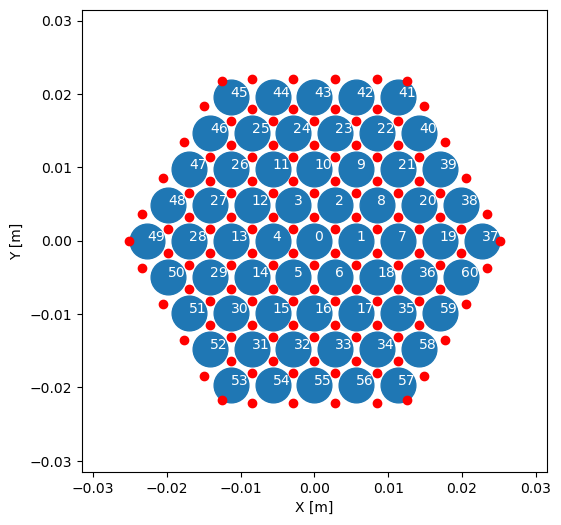

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6,6])
_rod_position = np.array(_rod_position)
plt.plot(_rod_position[:,0], _rod_position[:,1], 'o', markersize=25)
number = 0
for x, y in zip(_rod_position[:,0], _rod_position[:,1]):
    plt.text(x, y, str(number), color="white", fontsize=10)
    number += 1
for key in _subchannel_position:
    plt.plot(_subchannel_position[key][0], _subchannel_position[key][1], 'ro')
plt.ylabel('Y [m]')
plt.xlabel('X [m]')
plt.xlim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.ylim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.show()

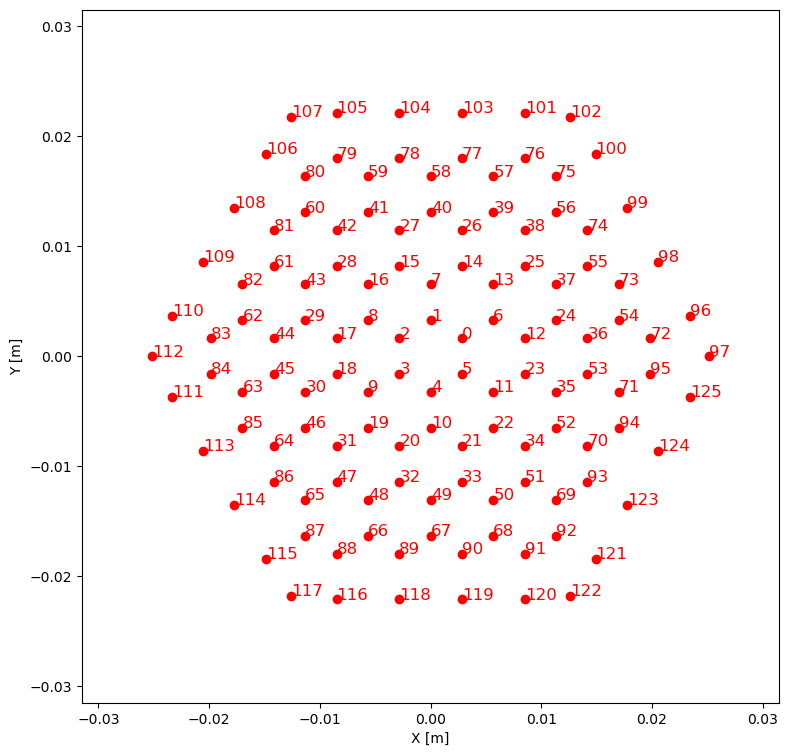

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=[9,9])
for key in _subchannel_position:
    plt.plot(_subchannel_position[key][0], _subchannel_position[key][1], 'ro')
number = 0
for key in _subchannel_position:
    plt.text(_subchannel_position[key][0], _subchannel_position[key][1], str(number), color="red", fontsize=12)
    number += 1
plt.ylabel('Y [m]')
plt.xlabel('X [m]')
plt.xlim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.ylim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
_rod_position = np.array(_rod_position)
#plt.plot(_rod_position[:,0], _rod_position[:,1], 'o', markersize=10)
for i, key in enumerate(_rod_position):
    if i < 7:
        plt.plot(_rod_position[i][0], _rod_position[i][1], 'ro', markersize=10)
    else:
        plt.plot(_rod_position[i][0], _rod_position[i][1], 'bo', markersize=10)
number = 0
# for x, y in zip(_rod_position[:,0], _rod_position[:,1]):
#     plt.text(x, y, str(number), color="white", fontsize=10)
#     number += 1
for key in _subchannel_position:
    plt.plot(_subchannel_position[key][0], _subchannel_position[key][1], 'go')
plt.ylabel('Y [m]')
plt.xlabel('X [m]')
plt.xlim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.ylim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
plt.grid()
plt.show()

: 

In [ ]:
height_traingle = _flat_to_flat/2
base_triangle = height_traingle*np.tan(np.pi/6)*2
total_area_assembly = (height_traingle * base_triangle)/2*6
covered_area = len(_rod_position)*(np.pi*_rod_diameter**2/4)
total_area_assembly - covered_area

: 

In [ ]:
for i in range(np.shape(_rod_position)[0]):
    print("{0:.4E} {1:.4E} 0.0".format(_rod_position[i,0], _rod_position[i,1]))

: 

In [ ]:
name_hot = 'hot_pin.i'
name_normal = 'pin.i'
print(name_hot + ' ', end='')
for i in range(1,np.shape(_rod_position)[0]):
    #print(str(i+1) + ": " + name_normal + ' ', end='')
    print(name_normal + ' ', end='')
    #if (i+1)%10 == 0: print()
    # print("{0}  - {1}".format(i, name_normal))

: 

In [ ]:
linear_power = 250e6/4/217*np.pi*0.8e-2**2
time = np.linspace(0,10,100)
power = 10*linear_power*np.sin(time*np.pi/10) + linear_power

plt.figure(dpi=100)
plt.plot(time, power)
plt.xlabel('Time [s]')
plt.ylabel('Linear Power [W/cm]')
plt.grid()

: 

: 

In [ ]:
import numpy as np

###################################
# Control parameters
###################################
_n_rings = 3
pitch = 7.26e-3
center = [0.0,0.0]

_rod_diameter = 5.84e-3
_flat_to_flat = 3.41e-2
_duct_to_rod_gap = (_flat_to_flat - (_n_rings - 1)*2*pitch)/2
###################################

# Defining input variables
x0 = 0.0;
y0 = 0.0;

x1 = 0.0;
y1 = 0.0;

a1 = 0.0;
a2 = 0.0

avg_coor_x = 0.0;
avg_coor_y = 0.0;

dist = 0.0;
dist0 = 0.0;

kgap = 0;
icorner = 0;
positive_flow = 1.0;
negative_flow = -1.0;

#################################
# Defining rod positions
#################################

theta = 0.0;
dtheta = 0.0;
distance = 0.0;
theta1 = 0.0;
theta_corrected = 0.0;
pi = np.pi;
k = 0;

_rod_position = [[0.0,0.0]];
for i in range(1,_n_rings):
    dtheta, theta = 2.0 * pi / (i * 6), 0.0;
    for j in range(i*6):
        k = k + 1;
        theta1 = (theta + 1.0e-10) % (pi / 3.0);
        distance = ((pow(i * pitch, 2) + (theta1 / dtheta * pitch)**2 -
                     2.0 * i * pitch * (theta1 / dtheta * pitch) * np.cos(pi / 3.0)))**0.5;
        theta_corrected = np.arccos(1.0 / (i * pitch) / distance / 2.0 *
          ((i * pitch)**2.0 + (distance)**2.0 - (theta1 / dtheta * pitch)**2.0));
        if (theta1 < 1.0e-6):
            theta_corrected = theta;
        else:
            if (theta > pi / 3.0 and theta <= 2.0 / 3.0 * pi):
                theta_corrected = theta_corrected + pi / 3.0;
            elif (theta > 2.0 / 3.0 * pi and theta <= pi):
                theta_corrected = theta_corrected + 2.0 / 3.0 * pi;
            elif (theta > pi and theta <= 4.0 / 3.0 * pi):
                theta_corrected = theta_corrected + pi;
            elif (theta > 4.0 / 3.0 * pi and theta <= 5.0 / 3.0 * pi):
                theta_corrected = theta_corrected + 4.0 / 3.0 * pi;
            elif (theta > 5.0 / 3.0 * pi and theta <= 2.0 * pi):
                theta_corrected = theta_corrected + 5.0 / 3.0 * pi;
        pos_x = center[0] + distance * np.cos(theta_corrected)
        pos_y = center[0] + distance * np.sin(theta_corrected)
        _rod_position.append([pos_x, pos_y])
        theta = theta + dtheta;
        
        
#################################
# Defining rod positions in rings
#################################
_nrods = len(_rod_position)
_rods_in_rings = {}; k=0
k += 1; _rods_in_rings[0] = [k];
for i in range(1,_n_rings):
    loc_list = []
    for j in range(0, i * 6):
        k+= 1; loc_list.append(k);
    _rods_in_rings[i] = loc_list
    

#################################
# Number of channels
#################################
chancount = 0
for j in range(_n_rings - 1):
    chancount += j * 6
_n_channels = chancount + _nrods - 1 + (_n_rings - 1) * 6 + 6;


#################################
# Suchannels positions
#################################
_subchannel_to_rod_map = {} # Reserve 3
_subch_type = {}
_n_gaps = _n_channels + _nrods - 1;
_gap_to_chan_map = {}
gap_fill = {}
_chan_to_gap_map = {} # Reserve 3
_gap_pairs_sf = {}
_chan_pairs_sf = {}
_gij_map = {}
_sign_id_crossflow_map = {} # Reserve 3
_gap_to_rod_map = {} # Reserve 2
_gap_type = {}
_subchannel_position = {} # Reserve 3

k = 0;
kgap = 0;

for i in range(1, _n_rings):
    # Find closest rod at back ring
    for j in range(len(_rods_in_rings[i])):
        if j == len(_rods_in_rings[i]) - 1:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j])
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][0])
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][0]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][0]-1][1]);
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j])
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][0])
            _gap_type[kgap] = 'center'
            kgap = kgap + 1;
        else:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j])
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j+1])
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][j+1]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][j+1]-1][1]);
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j])
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j+1])
            _gap_type[kgap] = 'center'
            kgap = kgap + 1;
            
        dist0 = 1.0e+5;
        _subchannel_to_rod_map[k].append(_rods_in_rings[i - 1][0])
        l0 = 0;
        
        for l in range(len(_rods_in_rings[i - 1])):
            dist = np.sqrt(pow(_rod_position[_rods_in_rings[i - 1][l]-1][0] - avg_coor_x, 2) +
                           pow(_rod_position[_rods_in_rings[i - 1][l]-1][1] - avg_coor_y, 2));
            if dist < dist0:
                _subchannel_to_rod_map[k][2] = _rods_in_rings[i - 1][l];
                l0 = l;
                dist0 = dist;
                
        _gap_to_rod_map[kgap] = []
        _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
        _gap_to_rod_map[kgap].append(_rods_in_rings[i - 1][l0]);
        _gap_type[kgap] = 'center';
        kgap = kgap + 1;
        _subch_type[k] = 'center';
        k = k + 1;
        
    # Find the closest rod at front ring
    for j in range(len(_rods_in_rings[i])):
        if j == len(_rods_in_rings[i]) - 1:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][0]);
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][0]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][0]-1][1]);
        else:
            _subchannel_to_rod_map[k] = []
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
            _subchannel_to_rod_map[k].append(_rods_in_rings[i][j+1]);
            avg_coor_x = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][0] + _rod_position[_rods_in_rings[i][j+1]-1][0]);
            avg_coor_y = 0.5 * (_rod_position[_rods_in_rings[i][j]-1][1] + _rod_position[_rods_in_rings[i][j+1]-1][1]);
            
        if (i == _n_rings - 1):
            _subch_type[k] = 'edge';
            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_type[kgap] = 'edge';
            _chan_to_gap_map[k] = []
            _chan_to_gap_map[k].append(kgap);
            kgap = kgap + 1;
            k = k + 1;
            
            if j % i == 0:
                _gap_to_rod_map[kgap] = []
                _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
                _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
                _gap_type[kgap] = 'corner';
                
                _subchannel_to_rod_map[k] = []
                _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
                _subchannel_to_rod_map[k].append(_rods_in_rings[i][j]);
                _chan_to_gap_map[k] = []
                _chan_to_gap_map[k].append(kgap - 1);
                _chan_to_gap_map[k].append(kgap);
                _subch_type[k] = 'corner';
                
                kgap = kgap + 1;
                k = k + 1;
                
        else:
            dist0 = 1.0e+5;
            l0 = 0;
            _subchannel_to_rod_map[k].append(_rods_in_rings[i + 1][0]);
            for l in range(len(_rods_in_rings[i + 1])):
                dist = np.sqrt(pow(_rod_position[_rods_in_rings[i + 1][l]-1][0] - avg_coor_x, 2) +
                       pow(_rod_position[_rods_in_rings[i + 1][l]-1][1] - avg_coor_y, 2));
                if dist < dist0:
                    _subchannel_to_rod_map[k][2] = _rods_in_rings[i + 1][l];
                    dist0 = dist;
                    l0 = l;

            _gap_to_rod_map[kgap] = []
            _gap_to_rod_map[kgap].append(_rods_in_rings[i][j]);
            _gap_to_rod_map[kgap].append(_rods_in_rings[i + 1][l0]);
            _gap_type[kgap] = 'center';
            kgap = kgap + 1;
            _subch_type[k] = 'center';
            k = k + 1;
            
            

for i in range(_n_channels):     
    if _subch_type[i] == 'center':
        for j in range(_n_gaps): 
            if (_gap_type[j] == 'center'):
                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1])) or
                   ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);


                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][1])) or
                  ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);

                if (((_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][1])) or
                  ((_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1]) and
                   (_subchannel_to_rod_map[i][2] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);
                    
    elif (_subch_type[i] == 'edge'):
        
        for j in range(_n_gaps):
            if _gap_type[j] == 'center':
                if (((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][0]) and
                 (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][1])) or
                 ((_subchannel_to_rod_map[i][0] == _gap_to_rod_map[j][1]) and
                 (_subchannel_to_rod_map[i][1] == _gap_to_rod_map[j][0]))):
                    try:
                        _chan_to_gap_map[i].append(j);
                    except:
                        _chan_to_gap_map[i] = [];
                        _chan_to_gap_map[i].append(j);
                    
        for k in range(_n_channels):
            icorner = 0;
            if (_subch_type[k] == 'corner' and _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[k][0]):
                if len(_chan_to_gap_map[i]) == 0: _chan_to_gap_map[i] = []
                _chan_to_gap_map[i].append(_chan_to_gap_map[k][1]);
                icorner = 1;
                break;
                
        for k in range(_n_channels):
            if (_subch_type[k] == 'corner' and _subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[k][0]):
                if len(_chan_to_gap_map[i]) == 0: _chan_to_gap_map[i] = []
                _chan_to_gap_map[i].append(_chan_to_gap_map[k][1] + 1);
                icorner = 1;
                break;
            
              
# for j in range(_n_gaps):
#     for i in range(_n_channels):
#         if (_subch_type[i] == 'center' or _subch_type[i] == 'edge'):
#             if ((j == _chan_to_gap_map[i][0]) or (j == _chan_to_gap_map[i][1]) or (j == _chan_to_gap_map[i][2])):
#                 if (_gap_to_chan_map[j][0] == 0 and gap_fill[j][0] == 0):
#                     _gap_to_chan_map[j][0] = i;
#                     gap_fill[j][1] = 1;
#                 elif (_gap_to_chan_map[j][1] == 0 and gap_fill[j][1] == 0):
#                     _gap_to_chan_map[j][1] = i;
#                     gap_fill[j][1] = 1;
#         elif (_subch_type[i] == 'corner'):
#             if ((j == _chan_to_gap_map[i][0]) or (j == _chan_to_gap_map[i][1])):
#                 if (_gap_to_chan_map[j][0] == 0 and gap_fill[j][0] == 0):
#                     _gap_to_chan_map[j][0] = i;
#                     gap_fill[j][0] = 1;
#                 elif (_gap_to_chan_map[j][1] == 0 and gap_fill[j][1] == 0):
#                     _gap_to_chan_map[j][1] = i;
#                     gap_fill[j][1] = 1;

for i in range(_n_channels):
    if (_subch_type[i] == 'center'):
        _subchannel_position[i] = [0,0]
        _subchannel_position[i][0] = (_rod_position[_subchannel_to_rod_map[i][0]-1][0] +
                                      _rod_position[_subchannel_to_rod_map[i][1]-1][0] +
                                      _rod_position[_subchannel_to_rod_map[i][2]-1][0]) / 3.0;
        _subchannel_position[i][1] = (_rod_position[_subchannel_to_rod_map[i][0]-1][1] +
                                      _rod_position[_subchannel_to_rod_map[i][1]-1][1] +
                                      _rod_position[_subchannel_to_rod_map[i][2]-1][1]) / 3.0;      
        
    elif (_subch_type[i] == 'edge'):
        for j in range(_n_channels):
            if (_subch_type[j] == 'center' and
                ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][0] and
                  _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][1]) or
                 (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][1] and
                  _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][0]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][2]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][2]-1][1];
                
            elif (_subch_type[j] == 'center' and
                 ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][0] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][2]) or
                  (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][2] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][0]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][1]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][1]-1][1];
                
            elif (_subch_type[j] == 'center' and
                 ((_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][1] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][2]) or
                  (_subchannel_to_rod_map[i][0] == _subchannel_to_rod_map[j][2] and
                   _subchannel_to_rod_map[i][1] == _subchannel_to_rod_map[j][1]))):
                x0 = _rod_position[_subchannel_to_rod_map[j][1]-1][0];
                y0 = _rod_position[_subchannel_to_rod_map[j][1]-1][1];
                
            # else:
            #     x0 = _rod_position[_subchannel_to_rod_map[j][0]-1][0];
            #     y0 = _rod_position[_subchannel_to_rod_map[j][0]-1][1];
                
            x1 = 0.5 * (_rod_position[_subchannel_to_rod_map[i][0]-1][0] +
                        _rod_position[_subchannel_to_rod_map[i][1]-1][0]);
            y1 = 0.5 * (_rod_position[_subchannel_to_rod_map[i][0]-1][1] +
                        _rod_position[_subchannel_to_rod_map[i][1]-1][1]);
            a1 = _rod_diameter / 2.0 + _duct_to_rod_gap / 2.0;
            a2 = np.sqrt((x1 - x0) * (x1 - x0) + (y1 - y0) * (y1 - y0)) + a1;
            _subchannel_position[i] = [0,0]
            _subchannel_position[i][0] = (a2 * x1 - a1 * x0) / (a2 - a1);
            _subchannel_position[i][1] = (a2 * y1 - a1 * y0) / (a2 - a1);
            
    elif (_subch_type[i] == 'corner'):
        x0 = _rod_position[0][0];
        y0 = _rod_position[0][1];
        x1 = _rod_position[_subchannel_to_rod_map[i][0]-1][0];
        y1 = _rod_position[_subchannel_to_rod_map[i][0]-1][1];
        a1 = _rod_diameter / 2.0 + _duct_to_rod_gap / 2.0;
        a2 = np.sqrt((x1 - x0) * (x1 - x0) + (y1 - y0) * (y1 - y0)) + a1;
        _subchannel_position[i] = [0,0]
        _subchannel_position[i][0] = (a2 * x1 - a1 * x0) / (a2 - a1);
        _subchannel_position[i][1] = (a2 * y1 - a1 * y0) / (a2 - a1);


name_normal = 'pin.i'
for i in range(np.shape(_rod_position)[0]):
    print(name_normal + ' ', end='')
print(" ")
_rod_position = np.array(_rod_position)
for i in range(np.shape(_rod_position)[0]):
    print("{0:.5f} {1:.5f} 0.0".format(_rod_position[i,0], _rod_position[i,1]))
    
    
# import matplotlib.pyplot as plt
# plt.figure(figsize=[6,6])
# _rod_position = np.array(_rod_position)
# plt.plot(_rod_position[:,0], _rod_position[:,1], 'o', markersize=25)
# number = 0
# for x, y in zip(_rod_position[:,0], _rod_position[:,1]):
#     plt.text(x, y, str(number), color="white", fontsize=10)
#     number += 1
# for key in _subchannel_position:
#     plt.plot(_subchannel_position[key][0], _subchannel_position[key][1], 'ro')
# plt.ylabel('Y [m]')
# plt.xlabel('X [m]')
# plt.xlim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
# plt.ylim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
# plt.show()

# import matplotlib.pyplot as plt
# plt.figure(figsize=[6,6])
# for key in _subchannel_position:
#     plt.plot(_subchannel_position[key][0], _subchannel_position[key][1], 'ro')
# number = 0
# for key in _subchannel_position:
#     plt.text(_subchannel_position[key][0], _subchannel_position[key][1], str(number), color="red", fontsize=12)
#     number += 1
# plt.ylabel('Y [m]')
# plt.xlabel('X [m]')
# plt.xlim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
# plt.ylim([-(_n_rings - 1)*pitch - 2*_rod_diameter, (_n_rings - 1)*pitch + 2*_rod_diameter])
# plt.show()

: 

In [ ]:
height_traingle = _flat_to_flat/2
base_triangle = height_traingle*np.tan(np.pi/6)*2
total_area_assembly = (height_traingle * base_triangle)/2*6
covered_area = len(_rod_position)*(np.pi*_rod_diameter**2/4)
total_area_assembly - covered_area

: 

: 